In [1]:
import json
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt

In [2]:
with open('LLM_Stats_Results.json', 'r') as fp:
    res = json.load(fp)


N_repeats = 100

message_types = ['no_context', 'side-effect-severe','side-effect-mild']#, 'side-effect-specific', 'side-effect-generic']
models = ['gpt-4o', 'gpt-4o-mini', 'gpt-3.5-turbo']

words = ['Rare',
#'Rare-Severe',
#'Rare-Mild event',
'Uncommon ',
'Unlikely',
#'Common-Severe event',
'Possible',
#'Common-Mild event',
'Common',
'Very Common',
'Probable',
'Likely',
'Usual',
"Very Likely",
]


In [3]:
import re
def clean(x):
    try: 
        return float(x)
    except ValueError as ex:
        match = re.search(r'\d+\.\d+', x)
        if match:
            return float(match.group(0))
        else:
            return np.nan


In [4]:
results = {'Value': [], 'Exp': [], 'Model': [], 'Term': []}

for model in models: 
    for message in message_types:
        for word in words:
            temp = [clean(x) for x in res[model][message][word]]

            results['Value'].extend(temp)
            results['Exp'].extend([message] * N_repeats)
            results['Model'].extend([model] * N_repeats)
            results['Term'].extend([word] * N_repeats)

results = pd.DataFrame(results)

In [18]:
# Assess model understanding of probability
grouped = results[results['Exp'] == 'no_context'].groupby(['Model', 'Term'])['Value']

means = grouped.mean().reset_index()
CIs = (grouped.std() * 1.96 / (np.sqrt(N_repeats-1))).reset_index()

In [19]:
means = means[means['Model'] == 'gpt-4o-mini'].drop(columns='Model').set_index('Term').T
CIs = CIs[CIs['Model'] == 'gpt-4o-mini'].drop(columns='Model').set_index('Term').T

In [20]:
human_probs_mean = {
 'Rare': 0.1,
 'Uncommon ': .1764,
 'Unlikely': .1771,
 'Possible': .4328,
 'Common': .5873,
 'Very Common': .6010,
 'Probable': .6987,
 'Likely': .7187,
 'Usual':.7538,
 'Very Likely': .8430}

human_probs_CI = {
 'Rare': .0201,
 'Uncommon ': .0416,
 'Unlikely': .0285,
 'Possible': .0662,
 'Common': .0832,
 'Very Common': .1774,
 'Probable': .028,
 'Likely': .01969,
 'Usual':.03849,
 'Very Likely': .04869}


res_human = pd.concat([pd.DataFrame(human_probs_mean, index = ['Mean']), pd.DataFrame(human_probs_CI, index = ['CI'])])

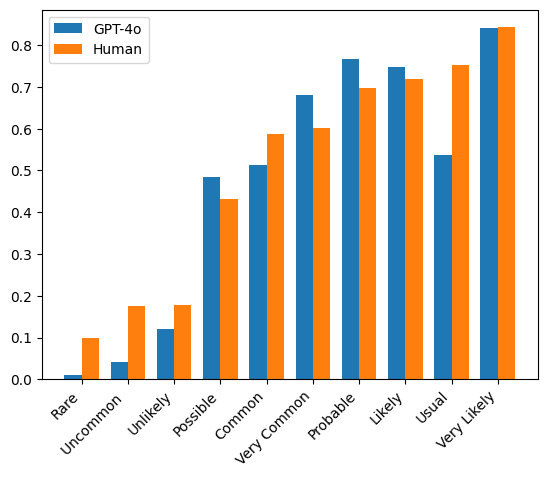

In [21]:
plt.bar(range(len(words)), means[words].values.reshape(-1), width=0.375, label = 'GPT-4o')
plt.bar(np.array(range(len(words))) + 0.375, res_human.loc['Mean', words].values.reshape(-1), width=0.375, label='Human')

plt.xticks(np.array(range(len(words))) + 0.375/2, words, rotation=45, ha='right')

plt.legend()

In [104]:
# EC_terms (https://health.ec.europa.eu/document/download/6a043dea-7d0f-4252-947b-cef58f53d37e_en#:~:text=This%20section%20should%20include%20all,of%20the%20three%2Dyearly%20PSUR.)
ec_terms = {
    'Common': [0.01, 0.1],
    'Uncommon': [0.001, 0.01],
    'Rare': [0.0001, 0.001],
}